# SKLOE PyDAS

A python package for experiment data analysis (FDAS in Python!).

Copyright &copy; 2018

**Contributors:**
* Zhichao Fang
* Xiaoxian Guo

## 使用方法
*或：*

1. `git clone https://github.com/JosephFang/pydas.git`至项目目录
2. `import CaseData`

*或：*

1. `git clone https://github.com/JosephFang/pydas.git` 至本地目录
2. 在site-packages添加一个路径文件，如pydas.pth，必须以.pth为后缀，写上保存 pydas.py 的本地所在的目录名称。
3. 在编写python脚本时，使用 `from CaseData import *`

**Get Started**: example.ipynb

**注意事项：**

1. 找不到python系统目录，可以使用以下命令查看系统python安装目录：

```python
import sys
sys.path
```

## 简介

基于python3.6环境开发，主要针对FDAS处理后的数据，进行进一步后处理，实现数据读入，数据处理，数据输出。

FDAS主要对单个工况数据进行处理，我们希望基于python开发流程化的后处理工具，提高工作效率，并提供python接口，可以实现更多的实时功能。

主要应用场景：

- 不同工况，同一通道的数据横向对比分析
- 标准化的批量报表自动生成
- 标准化流程化的数据后处理
- 便捷的自定义数据处理
- 应用于自动校波、校风

...

目前程序托管于GitHub，主页为：https://github.com/JosephFang/pydas

目前拥有以下功能：

1. *.out 文件读入与保存
2. 打印文件基本信息到显示屏，txt文本，excel文本 （包括：段数，通道数，采样频率，采样时间，前标定段信息，各个通道单位，通道名，系数，每段数据的采样点数，起止时间等）
3. 打印基本统计信息到显示屏，txt文本，excel文本 （包括：最大值，最小值，方差，均值，点数等）
4. 输出数据至*.mat文件或*.dat文件
5. 通道单位修复 （原out文件通道单位不能超过4个字符）
6. 实型值转换
7. 数据时域统计分析（高低频分离）（基于Pandas）
8. 校波文件读入与数据对其
9. 运动数据与加速度自动对其
10. 高低频滤波、取平均值

系统要求：
- Python >= 3.6.3
- Pandas >= 0.20.3
- Matplotlib >= 2.1.0
- Scipy >= 0.19.1
- PyFFTW >= 0.10.1（用于fft1d）

Windows下强烈推荐使用[Anaconda](https://www.anaconda.com)构建Python科学计算环境。

读入数据后，数据类型为pandas.DataFrame，基于pandas库的各种函数均可调用，请发挥你的想象力。

Pandas documents: https://pandas.pydata.org

后续处理可以应用pywafo开发统计处理模块，包括时域分析，频谱转换，极值预报，统计模型检验，疲劳分析等。

强烈推荐WAFO模块（Matlab, Python）: http://www.maths.lth.se/matstat/wafo/

更多功能会陆续推出，欢迎大家在Github平台参与代码开发

如有任何问题请联系：[xiaoxguo@sjtu.edu.cn](mailto:xiaoxguo@sjtu.edu.cn)


## 运行环境检测与数据读入

In [26]:
# 读入skloe_out库，进行操作
from CaseData import *

# 导入必要的依赖库
import sys
import numpy as np
import pandas as pd
import matplotlib
import scipy

# this limit maximum numbers of rows
pd.set_option('display.max_rows', 10)
# 图片显示
%matplotlib inline

In [27]:
# 检查python 运行环境
print('Python version ' + sys.version)
print('Numpy version ' + np.__version__)
print('Pandas version ' + pd.__version__)
print('Matplotlib version ' + matplotlib.__version__)
print('Scipy version ' + scipy.__version__)

Python version 3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
Numpy version 1.16.2
Pandas version 0.24.2
Matplotlib version 3.0.3
Scipy version 1.2.1


In [28]:
# 读入.out文件
case = CaseData('test.out', sseg=1)

Reading file test.out... Done!


基本读入命令：
```python
case = CaseData('XXXX.out', sseg=1)
```
`XXX.out` 为读入文件文件名

`sseg` 指定读入的数据段，`sseg`从0开始计数

注意：
1. 对于直接从采集系统里面出来的out文件，第0段为前标定段，第X段就是我们传统意义的第X段
2. 对于已经经过运动合并的数据，有且仅有一段，为第0段，应指定`sseg = 0`

## 数据基本信息显示

读入out文件后，case可以直接查看一些数据的基本信息，例如：

In [29]:
# 查看通道数
case.chN

3

这种方法，还可以查看以下相关信息：

- `case.segN`         数据段数
- `case.chN`          通道数
- `case.fs`           采样频率
- `case.scale`         数据类型 'prototype' or 'model'
- `case.lam`          数据缩尺比
- `case.filename`       读入数据文件名
- `case.date`          数据采样日期 MM-DD
- `case.segStatis`      所有通道数据统计值（最大值、最小值、均值、方差）
- `case.data`          数据（采用`pandas.dataFrame`格式），分段存储，如访问第一段使用`case.data[0]`
- `case.chInfo`        各个通道相关信息（通道号，通道名称，通道单位，通道转换系数）
- `case.segInfo`        各个数据段相关信息（段号，各段数据起止时间，采样数，采样时间，备注）

In [30]:
# 查看通道信息
case.chInfo

,Name,Unit,Coef
1,wave.front,cm,0.000617
2,wave.center,cm,0.000771
3,wave.back,cm,0.000908


In [31]:
# 查看各个数据段信息
case.segInfo

,Type,Start,Stop,Duration,N sample,Note
Seg 1,0,13:59:34.0,14:00:14.3,39.7s,7950,1.00s-12.70cm-7.00m-22.00s


In [32]:
# 直接查看数据 第0段前5行
case.data[0].head(5)

,wave.front,wave.center,wave.back
0,-0.074040,0.038570,-0.010897
1,-0.052445,0.053998,-0.016346
2,-0.043190,0.053998,0.003632
3,-0.035786,0.040113,0.021794
4,-0.030850,0.023913,0.044497


In [33]:
# 查看第0段的统计值信息 
case.segStatis[0]

,Mean,STD,Max,Min,Unit
wave.front,-0.070338,1.321586,7.745201,-6.787000,cm
wave.center,-0.124195,1.438787,8.262465,-7.293587,cm
wave.back,-0.120777,1.313337,8.137484,-6.610968,cm


## 数据调用相关

由于数据采用`pandas.DataFrame`格式，可以十分方便的进行数据引用，行索引为数据点，列索引为通道名

数据引用采用以下格式：

```python
case.data[n]['channel name']
```

n为第几段数据，后面直接引用通道名即可，通道名部分还可以给`list`，如`['F.line1','wave1']`同时提取多列指定数据，更加丰富的数据索引方法，参见pandas支持文档。

基于此，可以直接利用pandas库丰富的内建函数，实现简单的数理统计，以下为一些例子，请发挥你的想象力：

pandas documents online:http://pandas.pydata.org/pandas-docs/stable/

In [34]:
#显示第1段数据所有通道平均值 
case.data[0].mean()

wave.front    -0.070272
wave.center   -0.124577
wave.back     -0.120691
dtype: float64

In [35]:
#显示第1段数据相关数理统计信息
case.data[0].describe()

,wave.front,wave.center,wave.back
count,7950.000000,7950.000000,7950.000000
mean,-0.070272,-0.124577,-0.120691
std,1.321669,1.438878,1.313419
min,-6.787000,-7.293587,-6.610968
25%,-0.193584,-0.269990,-0.264030
50%,-0.059232,-0.042427,-0.042681
75%,0.073423,0.038570,0.040864
max,7.745201,8.262465,8.137484


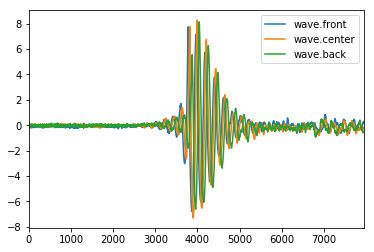

In [36]:
# 数据显示
case.data[0].plot()

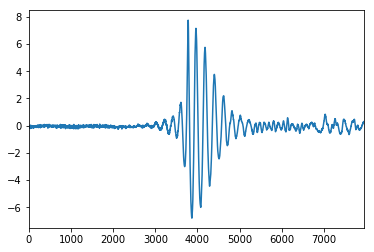

In [37]:
# 单独通道数据显示
case.data[0]['wave.front'].plot()

In [38]:
# 单独通道的数据提取

case.data[0]['wave.front'].values

array([-0.07404   , -0.052445  , -0.04319   , ...,  0.24433199,
        0.23260899,  0.29184099])

## 数据存储

数据可以存储为.out格式，通过以下命令：

```python
case.write('test-1.out', sseg='all')
```

数据导出提供以下两个直接可以用的方法：

1. `case.to_dat(header = True, time = True, sseg = 'all')` 默认导出所有段，或可导出指定段
    - `header` 是否导出通道名和单位
    - `time` 是否带时间项

2. `case.to_mat(sseg = 0)` 这里请输入正整数，导出为包含该段所有信息的.mat文件

以上两种方法，生成的文件均保存在运行文件目录下。

除此之外，还可直接利用pandas函数导出特定段，特定通道数据，例如:

```python
case.data[0]['F.line1'].to_csv('sd1.dat') # 导出第0段F.line1到*.dat文件
```

这种情况下，可以转存数据到TXT，EXCEL，HTML...

数据段信息也可导出或查看，提供以下直接可用的方法(可以打印到显示屏，TXT，EXCEL(下一版本会支持打印到粘贴版)):

1. `case.pInfo(printTxt=False,printExcel=False)`打印段落信息
2. `case.pChInfo(printTxt=False,printExcel=False)`打印通道信息
3. `case.pst(printTxt=False,printExcel=False)`打印统计值信息


In [39]:
# 导出到*.dat
case.to_dat(sseg = 0)

# 导出到*.mat
case.to_mat(sseg = 0)

Export: C:\Python\pydas/test_seg00-model.dat
Export: C:\Python\pydas/test


In [40]:
# 打印通道信息到屏幕

case.pChInfo(printTxt = False, printExcel = False)

--------------------------------------------------
      Name     Unit    Coef  
1   wave.front  cm   0.000617
2  wave.center  cm   0.000771
3    wave.back  cm   0.000908
--------------------------------------------------


## 实型值数据转换

目前可以根据输入各个通道单位，实现实型值转换，步骤如下：

1. 请检查读取单位是否有误，原out文件单位仅能占4个字节，故超过四个字节单位要修复，如deg/s2，kg.cm等

    检查通道：`case.pChInfo()`
    
    检查是否已经转换：`case.scale`

2. 修复单位，请用以下方法：`case.fix_unit(c_chN=['36','35'],unit=['kg.cm','kg.cm'])` #修改36，37通道单位为kg.cm
    
3. 转换数据到实型值：`case.to_fullscale()`

注意，一经转换所有信息将变为实型值，以上提到的针对数据处理的方法均可用，通道转换可识别所有常用单位。

In [41]:
case.fix_unit([1, 2], ['kg','kg'])

In [42]:
case.pChInfo()

--------------------------------------------------
      Name     Unit    Coef  
1   wave.front  kg   0.000617
2  wave.center  kg   0.000771
3    wave.back  cm   0.000908
--------------------------------------------------


## 通道操作

通道操作可以实现以下几个功能

- 删除通道
- 添加通道
- 提取通道
- 截取一定的长度 XXs 至 XXs
- 更改通道名
- 改变通道顺序


In [43]:
# 删除通道
case.delCh('wave.front') #直接输入要删除的通道名

wave.front has been removed


In [44]:
# 删除通道 通道名，单位，数据（np.array格式）
case.addCh('xxx', 'cm', np.zeros(case.data[0].shape[0]))
case.data[0]

xxxhas been added


,wave.center,wave.back,xxx
0,0.038570,-0.010897,0.0
1,0.053998,-0.016346,0.0
2,0.053998,0.003632,0.0
3,0.040113,0.021794,0.0
4,0.023913,0.044497,0.0
...,...,...,...
7945,-0.195164,-0.544860,0.0
7946,-0.211364,-0.542136,0.0
7947,-0.240677,-0.524882,0.0
7948,-0.263819,-0.510352,0.0


In [45]:
#提取通道 只保留相应的通道，删去其他
case.pickCh(['wave.center', 'wave.back'])
case.data[0]

,wave.center,wave.back
0,0.038570,-0.010897
1,0.053998,-0.016346
2,0.053998,0.003632
3,0.040113,0.021794
4,0.023913,0.044497
...,...,...
7945,-0.195164,-0.544860
7946,-0.211364,-0.542136
7947,-0.240677,-0.524882
7948,-0.263819,-0.510352


Cut time series from 10.00s to 50.00s


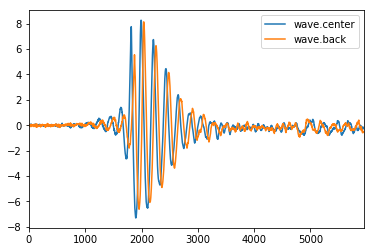

In [46]:
#截取一定的通道长度 start, stop 单位为秒
case.cutSeries(10,50)
case.data[0].plot()

In [47]:
#更改通道名称，请注意，不要与已有的通道名重复

case.renameCh('wave.center','center') #(原有通道名，新通道名)


In [49]:
# 通道重新排序 请提供新的通道名顺序list
case.changeChOder(['wave.back','center'])

Changed the Channel order.


## 通道数据处理

### 直接数据处理
目前拥有常用的通道数据处理能力:

- 低通滤波 `case.lowpassFilter(chName, cutoffull, replace, returnValue, sseg, order)`
  - `chName` 通道名
  - `cutoffull` 截止频率（rad/s，实型值）注意检查缩尺比 `case.lam`
  - `replace = True` 是否替换原值（默认True）
  - `returnValue = False` 是否输出低通替换的数据（默认False）
  - `sseg = 0` 第几段数据（默认0）
  - `order` 滤波阶数（默认6）
- 高通滤波 `case.lowpassFilter(chName, chutoffull, replace, returnValue, sseg, order)`
- 去除均值 `case.rmMean(chName, sseg = 0)`


进一步的数据处理可以直接将数据提取出来，进行操作，再将其对原有通道进行替换,例如

```python
mean = case.data[0]['wave.front'].mean() #提取均值
wavecase.highpassFilter('wave.front', cutoffull=0.2) # 用0.2rad/s进行高通滤波
wavecase.data[0]['wave.front'] = wavecase.data[0]['wave.front'] + mean #再把均值加回去
```

### 读入校波数据并自动与摇板对齐
```python
case.read_waveCal(wavefname=waveName, waveChName=['YB.cal', 'Cal.wave'],  waveUnit = ['deg', 'cm'])
```
使用前，请确认原数据中摇板通道命名为YB
- `waveName`：读入波浪数据的文件名，读入为带时间序列的.dat文件，
- `waveChName`: 读入的校波数据的通道名，可以与摇板一起导入多个校波波浪通道
- `waveUnit`: 读入通道的单位

### 将运动数据与力等传感器的数据对齐

现行的采集方法，无法保证运动数据与其他采集数据时间对齐，通过将运动Heave数据的二次微分结果与加速度求相关函数，将运动数据与其他采集数据时间对齐

注意，请确认数据包含运动通道。

```python
case.motion_ccor(accChName)
```

- `accChName`: 用于对齐的加速度通道，请确认使用在平台中心位置的加速度传感器垂向通道

### 高低频分离输出统计值Excel

```python
case.LHfreAnaly(sseg = 0, cutperiod = 24, Ncut = 10, pScreen = True, printExcel = True, printTxt = False)
```
- `sseg`: 第几段数据，默认0
- `cutperiod`: 高低频分离的实型值周期，单位s，默认24s
- `Ncut`: 前后截取一段，防止滤波问题，默认10
- `pScreen`: 打印到屏幕
- `printExcel`: 输出到Excel表格
- `printTxt`: 输出到txt文档
